In [1]:

import numpy as np
import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

import librosa
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd

from wave_net import WaveNet
from wave_net_utils import load_voices_files, get_max_length,fill_voices_data_with_pads, quantize_voices, get_voices_labels


In [2]:

model = WaveNet(30, layer_channels=16)
model.train()
# device = torch.device("cuda:0")
device = torch.device("cpu") 
print('use device: %s' % device, file=sys.stderr)
model = model.to(device)


use device: cpu


In [3]:


voices = load_voices_files(['dataset/dev/LJ050-0274.wav', 'dataset/dev/LJ050-0275.wav'])


labels, lengths = get_voices_labels(voices, 256)
print('labels.shape:', labels.shape)
labels = torch.from_numpy(labels).long()
criterion = nn.CrossEntropyLoss()
max_length = np.max(np.array(lengths)) 
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)
context = np.array(np.random.rand(2, max_length, 256))

for epoch in range(30): 
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs, _ = model(voices, context)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
    print('[%d] loss: %.3f' % (epoch + 1, loss.item()/len(voices) ))



labels.shape: (2, 201117)
[1] loss: 2.789
[2] loss: 2.785
[3] loss: 2.779
[4] loss: 2.775


KeyboardInterrupt: 

In [4]:
%matplotlib inline
# https://musicinformationretrieval.com/ipython_audio.html
# https://github.com/librosa/tutorial/blob/master/Librosa%20tutorial.ipynb

plt.figure(figsize=(14, 5))
outputs, lengths = model(voices, context)
reconstructed_voices = model.reconstruct_from_output(outputs, lengths)
# reconstructed_voices = reconstructed_voices / (65,536/2)
x = reconstructed_voices[0] / (65536/2)
x = x.cpu().detach().numpy()
# x = np.array(voices[0]) / (65536/2)
librosa.display.waveplot(x, sr=22000)
ipd.Audio(x, rate=22000)

NameError: name 'model' is not defined

In [5]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=22000, x_axis='time', y_axis='hz')

NameError: name 'x' is not defined

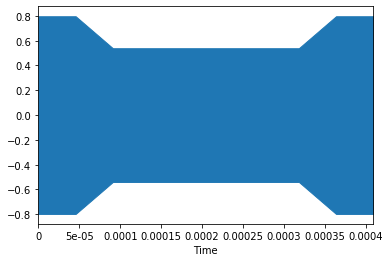

In [3]:
context = np.random.rand(1, 10, 16)
generated_voices = model.generate_voices(context)
x = generated_voices[0] / (65536/2)
librosa.display.waveplot(x, sr=22000)
ipd.Audio(x, rate=22000)